# TF-IDF
Pensamos en utilizar TF-IDF porque este método permite recuperar palabras clave a través de varios documentos, no sólo en uno como lo hace RAKE, además nosotros tomaremos como documentos cada oración que se dice en un lapso de tiempo según los subtítulos de Youtube y para recuperar los documentos verificaremos que todas las palabras dadas en la query estén también en él, asignandolé un score dado por TF-IDF y regresando el top 10.

In [1]:
from os import listdir
from os.path import isfile, join
import json
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords #Listas de stopwords
from nltk.tokenize import word_tokenize#Tokens
import re #regex
import pickle
from tqdm import tqdm 
from collections import Counter
import pandas as pd
from operator import itemgetter
import numpy as np
#Para graficar palabras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cargamos el corpus limpio

In [2]:
with open("../pkl/clean_videos.pkl", "rb") as f:
    videos = pickle.load(f)
videos[0][0]

{'id': 'L9YhoRatRzE',
 'original_title': 'Siempre Fui Yo | Adelanto | Disney+',
 'subtitles': [{'start': '0.13',
   'dur': '3.77',
   'text': ['tu', 'papá', 'tuvo', 'un', 'accidente']},
  {'start': '12.5', 'dur': '5.939', 'text': ['te', 'recuerdo', 'que', 'está']},
  {'start': '15.59', 'dur': '5.339', 'text': ['aquí']},
  {'start': '18.439',
   'dur': '6.361',
   'text': ['estaba', 'como', 'rabioso', 'con']},
  {'start': '20.929',
   'dur': '7.65',
   'text': ['especial', 'con', 'lucas', 'martín']},
  {'start': '24.8',
   'dur': '3.779',
   'text': ['necesito', 'saber', 'qué', 'fue', 'lo', 'que', 'pasó']},
  {'start': '29.42', 'dur': '2.479', 'text': ['aplausos']}]}

Juntamos todas las oraciones para calcular TF-IDF

In [3]:
def merge_videos(corpus):
    '''
    Mezcla los subtítulos de cada video en una entrada del
    diccionario (id, sub), 
    Guarda los diálogos por línea tokenizados y limpios

    Args:
        col (dic): Diccionario con los diálogos
    '''
    corpus_clean = []
    #Iteramos sobre los canales
    for chanel in tqdm(corpus):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                corpus_clean += [s['text'] for s in video['subtitles']]
    return corpus_clean

all_videos = merge_videos(videos)
all_videos[0]

100%|██████████| 9/9 [00:00<00:00, 46.69it/s]


['tu', 'papá', 'tuvo', 'un', 'accidente']

In [4]:
all_videos[5:10]

[['necesito', 'saber', 'qué', 'fue', 'lo', 'que', 'pasó'],
 ['aplausos'],
 ['decían', 'que', 'no', 'era', 'para', 'mí'],
 ['imposible'],
 ['que', 'nunca', 'lo', 'lograríamos']]

In [5]:
def flatten(lst):
    '''
    Junta las listas anidadas en una 

    Args:
        lst (list): Lista de listas
    '''
    return [item for sub in lst for item in sub]

Obtenemos las frecuencias de cada palabra en todo el corpus

In [6]:
term_frequencies = Counter(flatten(all_videos))

In [43]:
term_list = pd.DataFrame(sorted(term_frequencies.items(), key=itemgetter(1), reverse=True), 
                         columns=['Token','Frequency'])

term_list = term_list.set_index(term_list['Token'])
term_list.pop('Token')
term_list

,Frequency
Token,
de,217897
que,167644
la,128609
y,116389
el,105011
...,...
nananana,1
nía,1
llull,1


Calculamos el IDF de cada termino dentro de los documentos (todos los subtítulos de cada vídeo)

In [45]:
idf = {}
num_documents = len(all_videos)
for term in tqdm(term_list.index):
    #Total de documentos en que
    #aparece el término
    total_documents = 0
    for token_list in all_videos:
        if term in token_list:
            total_documents += 1
            
    #Asignación de idf
    idf[term] = -np.log2(total_documents/num_documents)

#Agregamos el idf al dataframe
term_list['idf'] = idf.values()
term_list = term_list.sort_values(by='idf', ascending=False)
#Lo guardamos
pickle.dump(term_list, open("../pkl/term_listxOracion.pkl", "wb"))

100%|██████████| 97791/97791 [4:01:33<00:00,  6.75it/s]  


In [7]:
with open("../pkl/term_listxOracion.pkl", "rb") as f:
    term_list = pickle.load(f)

term_list = term_list.sort_values(by='idf', ascending=False)
term_list[100:130]

,Frequency,idf
Token,,
jaibas,1,19.043465
glorimar,1,19.043465
bruma,1,19.043465
trees,1,19.043465
quillay,1,19.043465
cya,1,19.043465
altillo,1,19.043465
cbi,1,19.043465
nervo,1,19.043465


Nuestros documentos serán oraciones

In [8]:
#Parametro
a = 0.5

#Guarda los tfidf
tfidf = []
for token_list in tqdm(all_videos):
    if token_list != []:
        #Cuenta la frecuencia del término en el documento
        term_freq_doc = Counter(token_list)
        #print(term_freq_doc.values())
        #Obtiene la frecuencia mayor
        max_freq = np.max(list(term_freq_doc.values()))
        #Guarda tfidf por documento
        tfidf_doc = {}
        for term in term_freq_doc:
            #Valor de TF
            tf = a + (1-a)*(term_list["Frequency"][term]/max_freq)
            #Valor de tfidf
            tfidf_doc[term] = tf*term_list["idf"][term]
            
        tfidf.append(tfidf_doc)

100%|██████████| 540324/540324 [01:30<00:00, 6000.48it/s]


In [ ]:
pickle.dump(tfidf, open("../pkl/tfidfxOracion.pkl", "wb"))

In [6]:
with open("../pkl/tfidfxOracion.pkl", "rb") as f:
    tfidf = pickle.load(f)

tfidf[0:5]

[{'tu': 22108.738225139823,
  'papá': 2083.0025225599124,
  'tuvo': 2992.536775205195,
  'un': 100312.7542205603,
  'accidente': 871.2425900002974},
 {'te': 37241.07464552038,
  'recuerdo': 1686.5502163091887,
  'que': 159589.1466637399,
  'está': 35915.05555718361},
 {'aquí': 24448.057573994738},
 {'estaba': 10512.081302027222,
  'como': 60085.75580795781,
  'rabioso': 50.164611432806424,
  'con': 69495.68171121314},
 {'especial': 3815.105651978379,
  'con': 69495.68171121314,
  'lucas': 79.3677011885693,
  'martín': 318.46288535642265}]

## Vectores TF-IDF

Obtenemos el tamaño de oración más larga en el corpus

In [7]:
def get_max():
    '''
    Obtiene el tamaño de la oración más larga en el corpus
    '''
    max = 0
    for text in all_videos:
        max = len(text) if len(text) > max else max
    return max

Hacemos todos los vectores del mismo tamaño

In [8]:
def do_padding(vector, t):
    '''
    Agrega 0 al vector si no es del tamaño t 

    Args:
        vector (lst): lista de tamaño diferente
        t (int): Tamaño esperado del vector
    '''
    for i in range(0, t - len(vector)):
        vector.append(0)

In [9]:
def get_tfid_vectors(tfidf, corpus_tfidf):
    '''
    Por cada palabra de cada subtítulo se 
    busca su valor tfidf y se crea un vector con esos valores

    Args:
        tfid (dic): diccionario de palabras por vídeo
        corpus_tfidf (json): corpus a modificar
    '''
    max = get_max()
    print("Longitud de la oración más larga: ",max)
    i = 0
    for chanel in tqdm(corpus_tfidf):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    if s['text'] != []:
                        vector = list(tfidf[i].values())
                        do_padding(vector, max)
                        s["tfid"] = vector
                        i += 1

Obtenemos los vectores

In [10]:
get_tfid_vectors(tfidf, videos)
videos[0][0]

Longitud de la oración más larga:  56


100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


{'id': 'L9YhoRatRzE',
 'original_title': 'Siempre Fui Yo | Adelanto | Disney+',
 'subtitles': [{'start': '0.13',
   'dur': '3.77',
   'text': ['tu', 'papá', 'tuvo', 'un', 'accidente'],
   'tfid': [22108.738225139823,
    2083.0025225599124,
    2992.536775205195,
    100312.7542205603,
    871.2425900002974,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0]},
  {'start': '12.5',
   'dur': '5.939',
   'text': ['te', 'recuerdo', 'que', 'está'],
   'tfid': [37241.07464552038,
    1686.5502163091887,
    159589.1466637399,
    35915.05555718361,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0

Gráficamos los vectores de TF-IDF de cada oración 

In [11]:
def get_vectors():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for chanel in tqdm(videos):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    if s['text'] != []:
                        vectors[" ".join(s["text"])] = s["tfid"]
    return vectors

100%|██████████| 9/9 [00:00<00:00, 15.28it/s]
10it [00:00, 6857.92it/s]


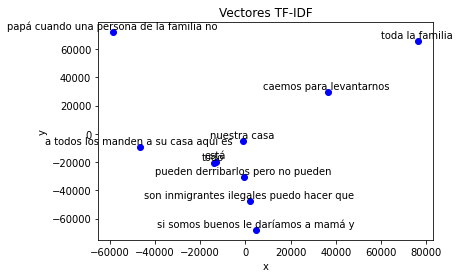

In [12]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(X,ids):
    '''
    Gráfica las oraciones dado su vector tfid

    Args:
        X (list): coordenadas del vector aplicando PCA
        ids (list): oraciones
    '''
    r=0
    plt.scatter(X[:,0],X[:,1], marker='o', c='blue')
    for label,x,y in tqdm(zip(ids, X[:,0], X[:,1])):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
        
mds_model = PCA(n_components=2)
vectors = get_vectors()
X_pca = mds_model.fit_transform(list(vectors.values()))
#Solo se gráfican algunas oraciones
plot_words(X_pca[20:30], list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Recuperación de Documentos con TFIDF

In [13]:
# tokens que necesitan ser limpiados del corpus y que no
# se encuentran en la lista de stopwords
more = ["si", "bien", "ahora", "así", "aquí", "pues"]
stopwords_list = stopwords.words('spanish') + more

def get_tokens_clean(text, stop_words=True):
    '''
    Genera los tokens de una cadena y los limpia
    (quita símbolos raros y stopwords)
    
    Args:
        text (str): cadena
    '''
    tokens = word_tokenize(text)
    clean = []
    pattern = r'[-_{}(),;:"#\/.¡!¿?·\[\]\'`]'
    for w in tokens:
        #quita stopwords y convierte a minúsculas
        w = re.sub(pattern,'', w.lower())
        if w != '':
            clean.append(w)
    return clean

Obtenemos los tados originales para regresar la cadena

In [14]:
def get_txt(path):
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    text = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    for file in onlyfiles:
        with open(path+"/"+file, 'rb') as f:
            text.append(json.loads(f.read().decode('utf-8', 'replace')))
    return text

# Guardamos los subtitulos de todos los canales
videos_original = get_txt("../corpus/data")#Nota: no print de todo

In [15]:
def recover_documents(query):
    """
    Función para recuperar documentos en base a su valor de TFIDF.
    
    Arguments
    ---------
    query : str
        Cadena a buscar
    tfidf_weights : dict
        Diccionario de tfidf por documentos y términos
    """
    #Obtener términos en query y procesarlos
    proc_query = flatten([get_tokens_clean(w) for w in query.split()])
    #Iteramos sobre los canales
    for chanel in videos:
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for i,s in enumerate(video['subtitles']):
                    score = 0
                    for w in proc_query:
                        #Revisa si todos los terminos de la query están en el documento
                        if w in s["text"]:
                            index = s["text"].index(w)
                            score += s["tfid"][index]
                    yield (video['id'], i), score

In [16]:
def get_original(id, index_sub):
    '''
    Regresa el texto original

    Args:
        id (str): id del vídeo
        index_sub (int): índice del subtítulo del vídeo
    '''
    for chanel in videos_original:
        for video in chanel:
            if video['id'] == id:
                if 'subtitles' in video:
                    return video['subtitles'][index_sub]

In [17]:
#Consulta
query = 'osos polares comen trigo'
#Resultados de la consulta
results = recover_documents(query)
#Ordena la consulta de mayor peso a menor
sorted_results = sorted(results, key=itemgetter(1), reverse=True)[:10]
print(len(sorted_results))
for doc, score in sorted_results:
    print('Id: {} \nInfo: {}\n score: {}\n ---------'.format(doc[0],get_original(doc[0], doc[1]), score))

10
Id: yUJf5r7wq8g 
Info: {'start': '2126.62', 'dur': '6.05', 'text': 'el chupi dio en el trigo en la trampa'}
 score: 73956.34187723468
 ---------
Id: IV-8YsyghbU 
Info: {'start': '292.31', 'dur': '3.66', 'text': 'No se trata sólo de pequeños momentos de "ajá", como cuando descubrimos que los osos y los niños'}
 score: 67720.42831617984
 ---------
Id: 01lKDkYSFDg 
Info: {'start': '415.03', 'dur': '5.53', 'text': 'los cultivos que sobraban. Por décadas siguientes los agricultores de cultivos como el maíz, trigo, algodón y soja'}
 score: 67720.42831617984
 ---------
Id: Ru2SPCDVpWo 
Info: {'start': '1021.28', 'dur': '4.41', 'text': 'millones de toneladas anuales, Rusia es\xa0\nya el mayor exportador de trigo a Egipto,'}
 score: 64738.932663555366
 ---------
Id: zQLxEH_t6AM 
Info: {'start': '92.32', 'dur': '4.66', 'text': '[Y también del Kimchi, esa cosa roja que\nparece que los coreanos comen a todas horas'}
 score: 64738.932663555366
 ---------
Id: L-Wtlev6suc 
Info: {'start': '265.37'

Probamos con el conjunto test para posteriormente evaluarlo

In [20]:
with open("../pkl/test.pkl", "rb") as f:
    test = pickle.load(f)

In [21]:
#Consulta
test_results = []

for query in tqdm(test):
    r = []
    results = recover_documents(query)
    #Ordena la consulta de mayor peso a menor
    sorted_results = sorted(results, key=itemgetter(1), reverse=True)[:5]
    for doc, score in sorted_results:
        r.append(get_original(doc[0], doc[1])['text'])
    test_results.append(r)

100%|██████████| 4535/4535 [2:02:54<00:00,  1.63s/it]  


In [23]:
pickle.dump(test_results, open("../pkl/resultsxOracion.pkl", "wb"))

In [24]:
with open("../pkl/resultsxOracion.pkl", "rb") as f:
    test_results = pickle.load(f)

for i in range(5):
    print(test[i], test_results[i])
    print("-------------")

a un lado oigan alejen a los demás viene ['dejéis a un lado los fanatismos no tiene', 'hare a un lado la batidora pues es momento\nde añadir los ingredientes secos que tamizamos.', 'Dejare a un lado mi batidora pues ire\nagregando los ingredientes secos.', 'Dejare a un lado mi batidora e ire\nincorporando los ingredientes secos...', 'Pon a un lado tu batidora y vacia \nlos ingredientes secos.']
-------------
saber lo que se está toda máquina ['saber lo que se está toda máquina', 'creo que se lo está perdiendo', 'ver que la gente se lo está creyendo y', 'bebé aún se alimenta de lo que está', 'es algo que se está perdiendo y si lo']
-------------
estás llorando que ya me involucre ['estás llorando que ya me involucre', 'Y ya sé que me vais a decir: ¡Fonseca, estás\xa0\nhaciendo trampa! Has empezado hablando de una\xa0\xa0', 'que me estás contando enrique venga ya y', 'caterina me parece que ya sabéis cuál es', 'a los brazos que ya me dirás tú qué']
-------------
especie ['no sabemos si s

In [ ]:
print(test[-908], test_results[-908])